# Use Advantage Actor-Critic to Play Acrobot-v1

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
torch.manual_seed(0)

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

22:23:09 [INFO] env: <AcrobotEnv<Acrobot-v1>>
22:23:09 [INFO] action_space: Discrete(3)
22:23:09 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
22:23:09 [INFO] reward_range: (-inf, inf)
22:23:09 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
22:23:09 [INFO] _max_episode_steps: 500
22:23:09 [INFO] _elapsed_steps: None
22:23:09 [INFO] id: Acrobot-v1
22:23:09 [INFO] entry_point: gym.envs.classic_control:AcrobotEnv
22:23:09 [INFO] reward_threshold: -100.0
22:23:09 [INFO] nondeterministic: False
22:23:09 [INFO] max_episode_steps: 500
22:23:09 [INFO] _kwargs: {}
22:23:09 [INFO] _env_name: Acrobot


In [3]:
class AdvantageActorCriticAgent:
    def __init__(self, env):
        self.gamma = 0.99

        self.actor_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,],
                output_size=env.action_space.n, output_activator=nn.Softmax(1))
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), 0.0001)
        self.critic_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,])
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.0002)
        self.critic_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.discount = 1.

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).reshape(1, -1)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                self.learn()
            self.discount *= self.gamma
        return action

    def close(self):
        pass

    def learn(self):
        state, _, _, action, next_state, reward, done, next_action \
                = self.trajectory[-8:]
        state_tensor = torch.as_tensor(state, dtype=torch.float).unsqueeze(0)
        next_state_tensor = torch.as_tensor(next_state, dtype=torch.float).unsqueeze(0)

        # calculate TD error
        next_v_tensor = self.critic_net(next_state_tensor)
        target_tensor = reward + (1. - done) * self.gamma * next_v_tensor
        v_tensor = self.critic_net(state_tensor)
        td_error_tensor = target_tensor - v_tensor

        # train actor
        pi_tensor = self.actor_net(state_tensor)[0, action]
        logpi_tensor = torch.log(pi_tensor.clamp(1e-6, 1.))
        actor_loss_tensor = -(self.discount * td_error_tensor * logpi_tensor).squeeze()
        self.actor_optimizer.zero_grad()
        actor_loss_tensor.backward(retain_graph=True)
        self.actor_optimizer.step()

        # train critic
        pred_tensor = self.critic_net(state_tensor)
        critic_loss_tensor = self.critic_loss(pred_tensor, target_tensor)
        self.critic_optimizer.zero_grad()
        critic_loss_tensor.backward()
        self.critic_optimizer.step()


agent = AdvantageActorCriticAgent(env)

22:23:09 [INFO] ==== train ====
22:23:11 [DEBUG] train episode 0: reward = -500.00, steps = 500
22:23:13 [DEBUG] train episode 1: reward = -500.00, steps = 500
22:23:15 [DEBUG] train episode 2: reward = -500.00, steps = 500
22:23:18 [DEBUG] train episode 3: reward = -500.00, steps = 500
22:23:20 [DEBUG] train episode 4: reward = -500.00, steps = 500
22:23:22 [DEBUG] train episode 5: reward = -500.00, steps = 500
22:23:24 [DEBUG] train episode 6: reward = -500.00, steps = 500
22:23:26 [DEBUG] train episode 7: reward = -500.00, steps = 500
22:23:28 [DEBUG] train episode 8: reward = -500.00, steps = 500
22:23:30 [DEBUG] train episode 9: reward = -500.00, steps = 500
22:23:33 [DEBUG] train episode 10: reward = -500.00, steps = 500
22:23:35 [DEBUG] train episode 11: reward = -500.00, steps = 500
22:23:37 [DEBUG] train episode 12: reward = -500.00, steps = 500
22:23:39 [DEBUG] train episode 13: reward = -500.00, steps = 500
22:23:41 [DEBUG] train episode 14: reward = -500.00, steps = 500
22:

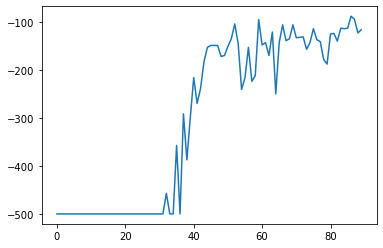

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()